In [5]:
from math import e, factorial,log, gamma, sqrt, floor
from matplotlib import pyplot as pt
from numpy.random import geometric,exponential,poisson
from scipy.stats import ks_2samp
from scipy.stats import norm
from numpy import linspace
from IPython.display import Markdown
from analysis import *
from threading import Thread
from timestamp import *
import re
import numpy as np


In [6]:
pt.rcParams["figure.figsize"] = (20,10)

# Load data

This is a comment


In [7]:
Ttx = 30
Trx = 60
Tn = 100
    
def compute_histogram(r1,r2):

    Eb1,Es1,En1 = computeEvents(r1,Ttx,Trx,Tn)
    Eb2,Es2,En2 = computeEvents(r2,Ttx,Trx,Tn)
    display(Markdown('<span style="color: #af0000">'+"P(S) = %.6f"%(Trx*Es1/len(r1))+'</span>'))
    display(Markdown('<span style="color: #00af00">'+"P(N) = %.6f"%(Tn*En1/len(r1))+'</span>'))
    display(Markdown('<span style="color: #0000af">'+"P(B) = %.6f"%(Ttx*Eb1/len(r1))+'</span>'))

    Pb2 = Eb2*Ttx/(Eb2*Ttx+En2*Tn+Es2*Trx)
    rt1 = Pb2/(Ttx/1000)
    
    print("r(B)(Events/s) = %.6f"%(rt1))
    
    hist1 = genWindowHistogram(r1,r2,1000)
    Esuc = checkSuccess(r2,r1)
    Ps=Esuc/Eb2
    rs2 = Esuc*1000/len(r1)
    print("r(Suuccess)(Events/s) = %.6f"%rs2)
    Pscan = Trx*Es1/len(r1)
    r_scan = 1000*Pscan/Trx
    print("r(S)(Events/s) = %.6f"%r_scan)
    Ns = Ps*1000/Ttx
    Nb = rt1*1000
    print("Success probability evts: %.6f"%(Ps))
    return hist1,Eb1,Es1,En1,Ps

In [23]:
MSG = re.compile(r'D[0-9]+-.*\*')
SENT = re.compile(r'[0-9]+:[0-9]+:[0-9]+\.[0-9]+')

def save(filename,data):
    with open(filename,'w') as fn:
        for d in data:
            print(d,file=fn)
            
def read_file(filename):
    with open(filename) as f:
        raw = f.readlines()
        return raw
    
def cleanup(line):
    return line.replace('(','').replace("'","").replace(')','').replace('b','').replace('\\t',',').replace('\\r\\n','').replace('"','').strip()
    
def read_data(raw):
    
    rec = []
    
    for line in raw:
        clean = cleanup(line)
        
        ssid = MSG.findall(clean)
        
        if len(ssid) > 0:
                                
            try:
                ls = clean.split(',')
                ts = TimeStamp(ls[0])
                ssid_str = ssid[0][1:18]
                rssi = int(ls[2][5:])
                rec.append((ts,ssid_str,rssi))
            except:
                print(clean)
                
                
    return rec

def get_sent(lines):
    
    sent = []
    for line in lines:
        if 'sent' in line:
            clean = cleanup(line)
            ls = clean.split(',')
            s = ls[2].replace('*','').replace('sent:','').strip()
            sent.append((ls[0],s))
    return sent

def sent_frequency(sent):
    t0 = TimeStamp(sent[0][0]).toSeconds()
    t1 = TimeStamp(sent[-1][0]).toSeconds()
    return len(sent)/(t1-t0)

def compute_ttx(raw):

    diff = []
  
    for line in raw:
        
        if 'dur' in line and 's-' not in line:
            clean = cleanup(line)
            ls = clean.split(',')
            s = ls[1].split(':')[1]
            d = float(s)
            diff.append(d)
            
    return diff

def compute_trx(raw):

    diff = []
  
    for line in raw:
        
        if 's-dur' in line:
            clean = cleanup(line)
            ls = clean.split(',')
            s = ls[1].split(':')[1]
            d = float(s)
            diff.append(d)
            
    return diff

def scan_frequency(raw):
   
    scans = []
  
    for line in raw:
        if 'S' in line:
            clean = cleanup(line)
            ls = clean.split(',')
            scans.append(ls[0])
    t0 = TimeStamp(scans[0]).toSeconds()
    t1 = TimeStamp(scans[-1]).toSeconds()
    return len(scans)/(t1-t0)


def analysis(res1,res2,n1,n2):
    rec = read_data(res2)
    
    tr = Thread(target=save,args=('received-%s.txt'%n2,rec))
    tr.start()
    sent = get_sent(res1)
    
    tr2 = Thread(target=save,args=('sent-%s.txt'%n1,sent))
    tr2.start()
      
    sent_set = set([s[1] for s in sent])
    rec_set = set([r[1].replace('*','') for r in rec])
    received = len(rec_set.intersection(sent_set))
    t0 = rec[0][0].toSeconds()
    t1 = rec[-1][0].toSeconds()
    
    print('Reception rate: ',len(rec)/(t1-t0))
    
    print('Success: %.6f%%'%(100*received/len(sent)))

    print('Transmission rate [msg/s]:', sent_frequency(sent))

            
    wnd = {}
    wnd[0] = []
    tref = rec[0][0].toSeconds()
    i = 0
    for r in rec:
        if r[0].toSeconds() - tref < 1:
            wnd[i].append(r)
        else:
            tref = r[0].toSeconds()
            i += 1
            wnd[i] = []
    hist = []
    for w in wnd:
        hist.append(len(wnd[w]))
    tr.join()
    tr2.join()
    return hist

    
res1 = read_file('res-1.txt')
res2 = read_file('res-2.txt')

h1 = analysis(res1,res2,'res-1','res-2')
h2 = analysis(res2,res1,'res2','res-1')
    
diff1 = compute_ttx(res1)
diff2 = compute_ttx(res2)
diff_r1 = compute_trx(res1)
diff_r2 = compute_trx(res2)
B = 0
S = 0
for line in res1:
    if '>' in line:
        B+=1
    if 'S' in line:
        S+=1
Btime = B*np.average(diff1)/1000
Stime = S*np.average(diff_r1)/1000
print('B1(%): ',100*Btime/(Btime+Stime))
print('S1(%): ',100*Stime/(Btime+Stime))

B = 0
S = 0
for line in res2:
    if '>' in line:
        B+=1
    if 'S' in line:
        S+=1
Btime = B*np.average(diff2)/1000
Stime = S*np.average(diff_r2)/1000
print('B2(%): ',100*Btime/(Btime+Stime))
print('S2(%): ',100*Stime/(Btime+Stime))

#plt.hist(h1,bins=20,density=True,histtype='bar')
#plt.hist(h2,density=True,histtype='step')
#plt.show()

Reception rate:  7.452668216555029
Success: 45.327488%
Transmission rate [msg/s]: 16.44175814993499
Reception rate:  7.72913877409244
Success: 47.109348%
Transmission rate [msg/s]: 16.405130173901313
B1(%):  49.78240074513701
S1(%):  50.21759925486299
B2(%):  49.73542679935949
S2(%):  50.264573200640505


In [24]:
leg = [20,30,40,50,60,70,80,90]
f1 = open("r4-d0-result.txt")
raw1 = f1.read()
f1.close()

f2 = open("r4-d1-result.txt")
raw2 = f2.read()
f2.close()

hist,Eb,Es,En,Ps = compute_histogram(raw1,raw2)
    


<span style="color: #af0000">P(S) = 0.500140</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.499860</span>

r(B)(Events/s) = 16.667159
1.0
r(Suuccess)(Events/s) = 8.333480
r(S)(Events/s) = 8.335659
Success probability evts: 0.500045


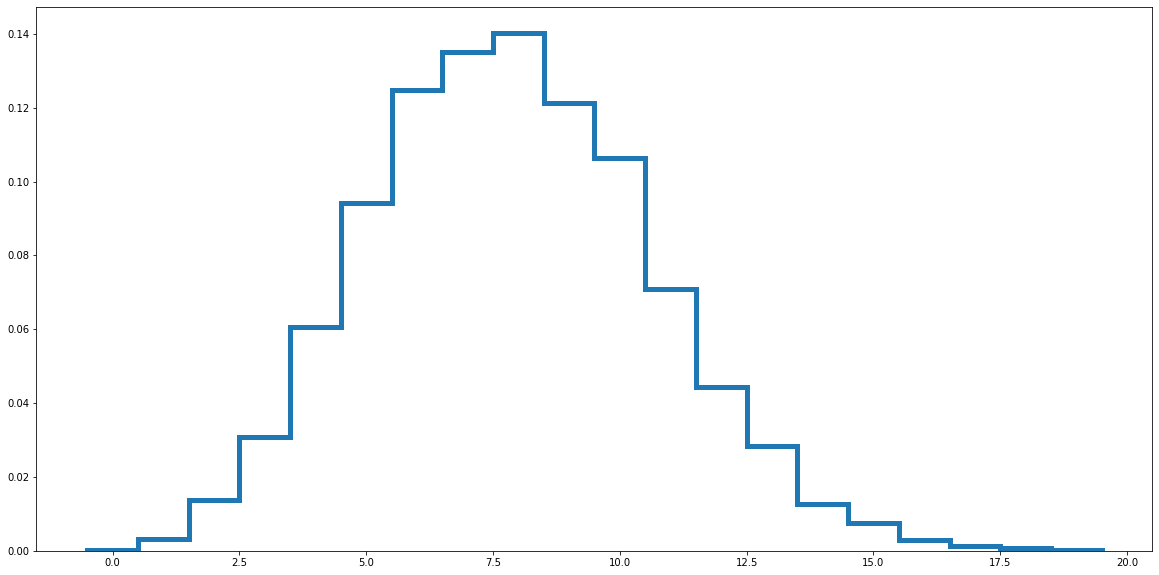

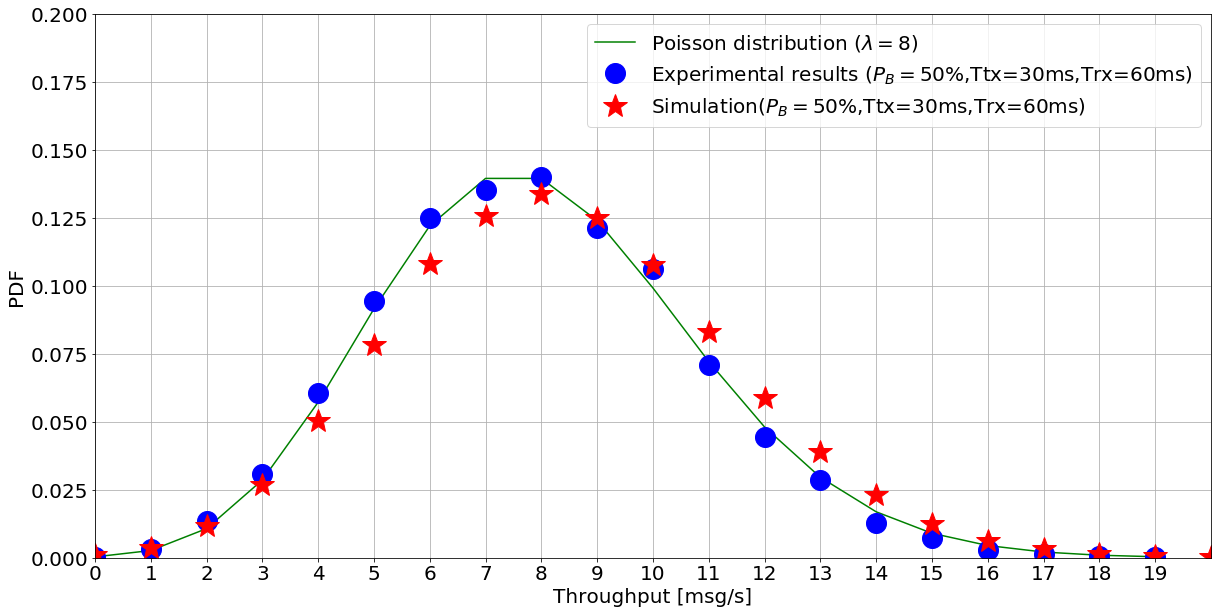

In [58]:
def pois(l,k):
    v = []
    for x in range(k):
        p = (l**x)*exp(-l)/factorial(x)
        v.append(p)
    return v

h,b,p = pt.hist(h2,bins=20,density=True,histtype='step',label="Experimental results",align="left",linewidth=5)
pt.show()

p = pois(8,20)
pt.plot(range(20),p,'-g',markersize=25,label='Poisson distribution ($\lambda = 8$)')
pt.plot(range(len(h)),h,'ob',label="Experimental results ($P_B =50\%$,Ttx=30ms,Trx=60ms)",markersize=20)
pt.plot(range(len(hist)),hist,'*r',markersize=25,label="Simulation($P_B =50\%$,Ttx=30ms,Trx=60ms)")

pt.axis([0,20,0,0.2])
pt.xticks(range(20), [str(n) for n in range(20)],fontsize=20)
pt.yticks(fontsize=20)
pt.xlabel(r'Throughput [msg/s]', fontsize = 20)
pt.ylabel(r'PDF', fontsize = 20)
pt.legend(fontsize=20)
pt.grid(True)
pt.savefig('sim_vs_experiment.pdf',format='pdf',dpi=300, bbox_inches='tight')
pt.show()

[0.00033546262790251185, 0.002683701023220095, 0.01073480409288038, 0.02862614424768101, 0.05725228849536202, 0.09160366159257924, 0.12213821545677231, 0.13958653195059692, 0.13958653195059692, 0.1240769172894195, 0.09926153383153559, 0.07219020642293499, 0.048126804281956655, 0.029616494942742554, 0.01692371139585289, 0.009025979411121541, 0.004512989705560771, 0.0021237598614403624, 0.0009438932717512722, 0.00039742874600053567]


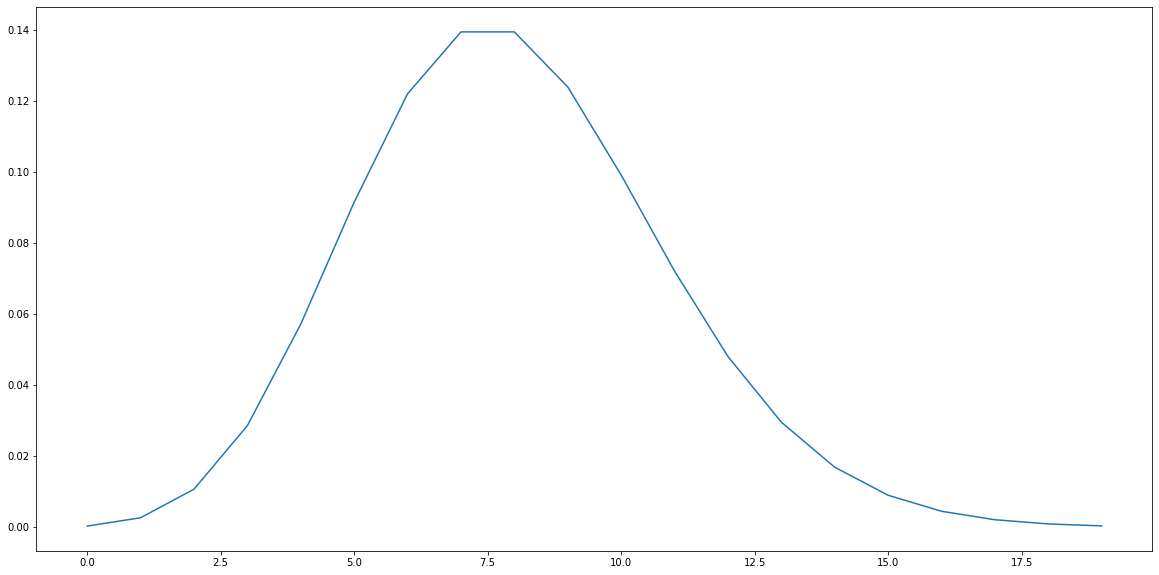

In [51]:
def pois(l,k):
    v = []
    for x in range(k):
        p = (l**x)*exp(-l)/factorial(x)
        v.append(p)
    return v


p = pois(8,20)
print(p)
pt.plot(p)
pt.show()